# Checking_GPU_Availabilty

In [1]:
import torch
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650'

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# CMD Tensorboard

### tensorboard --logdir="C:\Users\User\OneDrive - University College London\UCL Education\Year 4\MLS\Coursework\AMLS_assignment24_25\Task A\runs\DisplayImage"

# Library imports, data loading and visualisation


In [69]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import medmnist
from medmnist import BreastMNIST
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import os
import shutil

import os
from tensorboard import program

import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
from torch import optim  # For optimizers like SGD, Adam, etc.
from tqdm import tqdm  # For nice progress bar!
import torchvision.datasets as datasets  # Standard datasets

from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

## Loading datatsets from BreastMNIST

In [2]:
transform = transforms.Compose([
    # transforms.RandomAdjustSharpness(p=1,sharpness_factor=1.1),
    # transforms.RandomEqualize(p=0.3),
    # transforms.RandomVerticalFlip(p=0.1),
    # transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))  # Mean and standard deviation for grayscale images
])
#Cannot blindly augment the data to what we want
#the classifiers depend on the chape of the tumer hence all the below is good
#Might consider increaasing the contrast and brightness to allow easier identificationn
#CANCEL contrast... USE histogram equaliser instetad
transforms.RandomVerticalFlip()
transforms.RandomHorizontalFlip()
transforms.RandomRotation(degrees=180)
transforms.RandomEqualize(p=1)
transforms.RandomAdjustSharpness(p=1,sharpness_factor=2)

RandomAdjustSharpness(sharpness_factor=2,p=1)

In [97]:
batch_size=64
#loading train,val,test into variables
train_data=medmnist.BreastMNIST(split="train",transform=transform)
val_data=medmnist.BreastMNIST(split="val",transform=transforms.ToTensor())
test_data=medmnist.BreastMNIST(split="test",transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)


# Data augmentation and class balancing

In [224]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from collections import Counter



# Instantiate the dataset
dataset = medmnist.BreastMNIST(split="train",transform=transform)

# Count class occurrences
class_counts = Counter(dataset.labels.reshape(-1))
print(f"Class distribution before oversampling: {class_counts}")

# Compute sample weights: Inverse of class frequencies
class_weights = 1.0 / torch.tensor([class_counts[cls] for cls in sorted(class_counts.keys())], dtype=torch.float)
sample_weights = torch.tensor([class_weights[label] for label in dataset.labels.reshape(-1)], dtype=torch.float)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoader with sampler
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)
train_data=dataloader
# Check the distribution of classes in a few batches
for batch_idx, (data, labels) in enumerate(dataloader):
    print(f"Batch {batch_idx+1} class distribution: {Counter(labels.reshape(-1).tolist())}")
    if batch_idx == 2:  # Check only the first 3 batches
        break

# Initialize a Counter for tracking class counts
total_class_counts = Counter()

# Iterate through the entire dataloader
for data, labels in dataloader:
    # Flatten the labels and convert them to a list
    total_class_counts.update(labels.reshape(-1).tolist())

# Print the total distribution of classes
print(f"Total class distribution in the dataloader: {total_class_counts}")
print(len(dataloader)*32)

Class distribution before oversampling: Counter({1: 399, 0: 147})
Batch 1 class distribution: Counter({0: 17, 1: 15})
Batch 2 class distribution: Counter({0: 17, 1: 15})
Batch 3 class distribution: Counter({0: 19, 1: 13})
Total class distribution in the dataloader: Counter({1: 299, 0: 247})
576


In [87]:
data, labels=next(iter(train_loader))
x=labels.view(-1)
x=x.tolist()
print(x)
Counter(x)

[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]


Counter({1: 52, 0: 12})

# Loading Example mnist dataset

In [8]:
# Hyperparameters
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 5

# Load Data
train_dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Debugging and testing

In [8]:

# print(train_data)
# print("=====================")
# print(val_data)
# print("=====================")
# print(test_data)

for i, (images, labels) in enumerate(train_loader):
    print(images.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

In [43]:
#visualising the size of the image and its labels
one=0
zero=0
for image , label in train_data:
    # print(image.shape)
    # print(label)
    if label==0:
        zero+=1
    else:
        one+=1
print(one)
print(zero)

399
147


### Displaying images on Tensorboard

In [11]:
#location of tensorboard folder
folder="runs/DisplayImage"

In [164]:
clear_folder(folder)
#show using dataset on tensorboard
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
writer = SummaryWriter(f"runs/DisplayImage")
for index in range(100):
    data,label=train_data[index]
    writer.add_image("mnist_images", data,index)
    
writer.close()

Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Train'
Deleted: runs/DisplayImage\events.out.tfevents.1733867044.DESKTOP-3FC1MTH.29016.68
All contents of the folder 'runs/DisplayImage' have been cleared.


In [150]:
clear_folder(folder)
#show using dataloader with batches
for batch_idx, (data, targets) in enumerate(train_loader):
    # create grid of images
    img_grid = torchvision.utils.make_grid(data)
    # write to tensorboard
    writer.add_image(f"MNIST Example - image batch ", img_grid,batch_idx)
    #print(batch_idx)
writer.close

Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Train'
Deleted: runs/DisplayImage\events.out.tfevents.1733866663.DESKTOP-3FC1MTH.29016.63
All contents of the folder 'runs/DisplayImage' have been cleared.


<bound method SummaryWriter.close of <torch.utils.tensorboard.writer.SummaryWriter object at 0x0000022A861F86A0>>

### Displaying image

torch.Size([28, 28])


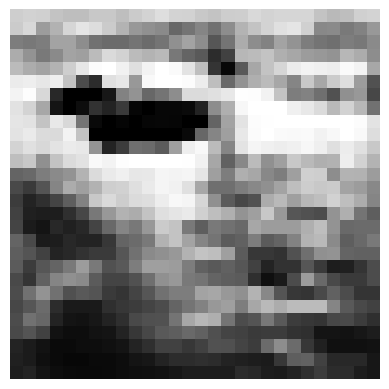

In [165]:
img,label = train_data[1]
image_np = img.squeeze()
print(image_np.shape)
# Plot the image
plt.imshow(image_np,cmap="gray")
plt.axis('off')  # Hide the axes for better visualization
plt.show()

# Functions

## Check GPU

In [4]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda


'NVIDIA GeForce GTX 1650'

In [101]:

# Function to copy tensor files save
def copy_directory(source_dir, destination_dir):
    """
    Copies all files and folders from a source directory to a destination directory.

    Args:
        source_dir (str): The path to the source directory.
        destination_dir (str): The path to the existing destination directory.
    """
    try:
        # Ensure the destination directory exists
        if not os.path.isdir(destination_dir):
            print(f"Error: Destination directory '{destination_dir}' does not exist.")
            return

        # Copy the content of source dir to destination directory
        shutil.copytree(source_dir, os.path.join(destination_dir, os.path.basename(source_dir)))
        print(f"Successfully copied the content of '{source_dir}' to '{destination_dir}'")

    except FileNotFoundError:
        print(f"Error: Source directory '{source_dir}' not found.")
    except shutil.Error as e:
        print(f"Error during copy: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")



#function to clear tensorboard files

def clear_folder(folder_path):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"The folder '{folder_path}' does not exist.")
        return
    
    # Iterate through all items in the folder
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        try:
            # Remove directories
            if os.path.isdir(item_path):
                shutil.rmtree(item_path)
            # Remove files
            else:
                os.remove(item_path)
            print(f"Deleted: {item_path}")
        except Exception as e:
            print(f"Failed to delete {item_path}: {e}")
    
    print(f"All contents of the folder '{folder_path}' have been cleared.")
    #location of tensorboard folder
folder="runs/DisplayImage"


class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        """
        Here we define the layers of the network. We create two fully connected layers

        Parameters:
            input_size: the size of the input, in this case 784 (28x28)
            num_classes: the number of classes we want to predict, in this case 2 (0-1)

        """
        super(NN, self).__init__()
        # # Our first linear layer take input_size, in this case 784 nodes to 50
        # # and our second linear layer takes 50 to the num_classes we have, in
        # # this case 10.
        # self.fc1 = nn.Linear(input_size, 50)
        # self.fc2 = nn.Linear(50, num_classes)

        self.flatten = nn.Flatten() #flattens the input tensors
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Linear(50, 2),
            # nn.ReLU(),
            # nn.Linear(512, 2)
        )

    def forward(self, x):
        """
        x here is the mnist images and we run it through the network that we created above.
        Parameters:
            x: mnist images
        Returns:
            out: the output of the network
        """
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(  #same convolution
            in_channels=in_channels,
            out_channels=8,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16, 
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

class NN2(nn.Module):
    def __init__(self, input_size, num_classes):
        """
        Here we define the layers of the network. We create two fully connected layers

        Parameters:
            input_size: the size of the input, in this case 784 (28x28)
            num_classes: the number of classes we want to predict, in this case 10 (0-9)

        """
        super(NN2, self).__init__()
        # Our first linear layer take input_size, in this case 784 nodes to 50
        # and our second linear layer takes 50 to the num_classes we have, in
        # this case 10.
        self.flatten = nn.Flatten() #flattens the input tensors
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)

        Parameters:
            x: mnist images

        Returns:
            out: the output of the network
        """
        x=self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    accuracies=[]
    batch_loss=0
    for batch, (input_data, class_cat) in enumerate(tqdm(dataloader)):
        input_data, class_cat = input_data.to(device), class_cat.to(device)

        ## Compute prediction error
        pred = model(input_data)
        class_cat=class_cat.squeeze().long()
        loss = loss_fn(pred, class_cat)

        ## Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        ## calculation running loss
        loss, current = loss.item(), (batch + 1) * len(input_data)


        ##caculating running accuracy
        _, predictions = pred.max(1)
        num_correct = (predictions == class_cat).sum()
        running_train_acc = float(num_correct) / float(input_data.shape[0])
        # print("model Output>>>>>")
        # print(pred)
        # print("predictions>>>")
        # print(predictions)
        # print("num_correct>>>>>")
        # print(num_correct)
        # print("accuracy>>>>")
        # print(running_train_acc)
        # print(data.shape[0])
        # print(input_data.shape[0])
        accuracies.append(running_train_acc)

        ##Plot stuff to tensorboard tensorboard
        global step
        writer.add_scalar("Batch/Training loss",loss,global_step=step)
        writer.add_scalar("Batch/Training Accuracy", running_train_acc, global_step=step)
        # global batch_loss
        # batch_loss.append(loss)
        batch_loss+=loss

        
        step += 1


        #print(f"loss: {loss:>7f} accuracy: {running_train_acc:>5f}  [{current:>5d}/{size:>5d}]")
    
    ## Calculate epoch accuracy
    epoch_accuracy=sum(accuracies)/len(accuracies)

    ## Getting the average epoch loss
    epoch_loss=batch_loss/size
    
    ## Send it to tensorboard
    writer.add_scalars("Epoch/Epoch loss",{'Train':epoch_loss},global_step=epoch)
    writer.add_scalars("Epoch/Epoch Accuracy",{"Train":epoch_accuracy},global_step=epoch)
    
def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y=y.squeeze().long()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    writer.add_scalars("Epoch/Epoch loss",{'Test':test_loss},global_step=epoch)
    writer.add_scalars("Epoch/Epoch Accuracy",{"Test":correct},global_step=epoch)
    print(f"val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y = y.squeeze().long()
            pred = model(X)
            # Collect predictions and true labels
            all_labels.append(int(y))
            all_predictions.append(int(pred.argmax(1)))
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculate accuracy
    correct /= size

    # Build confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_names = ["False", "Positive"]  # Update as needed for your use case

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()  # Ensure labels fit within figure boundaries
    plt.show()
    # Convert plot to image
    fig = plt.gcf()
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)
    plt.close(fig)  # Close figure to free memory

    # Log image to TensorBoard
    writer.add_image("Confusion Matrix", np.transpose(image, (2, 0, 1)), global_step=epoch)

    # Log accuracy to TensorBoard
    writer.add_scalar("Test Accuracy", correct, global_step=epoch)

    # Print accuracy
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%\n")

print("Done")

def savemodel(model_name,model,tensor_path):
    try:
        os.mkdir("only_one_folder") # Will not create parent folders, unlike os.makedirs()
        print(f"Folder created successfully")
    except OSError as e:
        print(f"Error creating folder: {e}")    


Done


In [27]:
#basinc testing for the model
model=CNN()
x=torch.randn(20,1,28,28)
print(model(x).shape)

model=NN(input_size=28*28,num_classes=2)
x=torch.randn(20,1,28,28)
print(model(x).shape)

torch.Size([20, 10])
torch.Size([20, 10])


# Fully connected network


In [ ]:
# Hyperparameters
input_size = 28*28
num_classes = 2
learning_rate = 0.001
#batch_size = 64 Note: this was determined when we loaded the data previously
num_epochs = 100

model = NN(input_size=input_size, num_classes=num_classes).to(device)
print(model)
## Setting up training and test function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

##clear tensorboard folder
clear_folder(folder)
writer = SummaryWriter(f"runs/DisplayImage")

#show using dataset on tensorboard
for index, (data,label) in enumerate(train_loader):
    data,label=train_data[index]
    writer.add_image("mnist_images", data,index)

# Visualize model in TensorBoard
example_img, labels = next(iter(train_loader))
#example_img=example_img[0]
writer.add_graph(model,example_img.to(device))
print("Model sent to tensorboard")

step=0
# epoch_loss=[]
for t in range(num_epochs):
    epoch=t
    # batch_loss=[]
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    
    # epoch_loss.append(sum(batch_loss)/len(batch_loss))
    # writer.add_scalar("Epoch Training loss",epoch_loss[t],global_step=t)
    val(test_loader, model, loss_fn)

print("Done!")

NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=2, bias=True)
  )
)
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Train'
Deleted: runs/DisplayImage\events.out.tfevents.1733967021.DESKTOP-3FC1MTH.3756.1
All contents of the folder 'runs/DisplayImage' have been cleared.
Model sent to tensorboard
Epoch 1
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 88.25it/s]


Test Error: 
 Accuracy: 73.1%, Avg loss: 0.000000 

Epoch 2
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 93.47it/s]


Test Error: 
 Accuracy: 73.1%, Avg loss: 0.000000 

Epoch 3
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 100.35it/s]

Test Error: 
 Accuracy: 73.7%, Avg loss: 0.000000 



Epoch 4
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 78.98it/s]


Test Error: 
 Accuracy: 73.1%, Avg loss: 0.000000 

Epoch 5
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 93.33it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.000000 

Epoch 6
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 91.56it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.000000 

Epoch 7
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 103.79it/s]

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.000000 



Epoch 8
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 87.86it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.000000 

Epoch 9
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 103.76it/s]

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.000000 



Epoch 10
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 87.00it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.000000 

Epoch 11
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 104.97it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.000000 

Epoch 12
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 95.80it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.000000 



Epoch 13
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 102.77it/s]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.000000 

Epoch 14
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 103.88it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.000000 

Epoch 15
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 86.68it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.000000 



Epoch 16
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 96.83it/s]

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.000000 

Epoch 17
-------------------------------



100%|██████████| 9/9 [00:00<00:00, 102.03it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.000000 

Epoch 18
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 100.46it/s]

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.000000 



Epoch 19
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 105.98it/s]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.000000 

Epoch 20
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.19it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.000000 

Epoch 21
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 103.55it/s]

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.000000 



Epoch 22
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 95.46it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.000000 

Epoch 23
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 103.31it/s]

Test Error: 
 Accuracy: 76.3%, Avg loss: 0.000000 

Epoch 24
-------------------------------



100%|██████████| 9/9 [00:00<00:00, 96.81it/s]

Test Error: 
 Accuracy: 76.3%, Avg loss: 0.000000 



Epoch 25
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 90.61it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.000000 

Epoch 26
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 102.90it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.000000 

Epoch 27
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 96.16it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.000000 

Epoch 28
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 100.50it/s]

Test Error: 
 Accuracy: 76.3%, Avg loss: 0.000000 



Epoch 29
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 94.41it/s]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.000000 

Epoch 30
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.62it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.000000 

Epoch 31
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 97.99it/s]

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.000000 



Epoch 32
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 107.17it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.000000 

Epoch 33
-------------------------------



100%|██████████| 9/9 [00:00<00:00, 93.65it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.000000 

Epoch 34
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 104.11it/s]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.000000 

Epoch 35
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.18it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.000000 



Epoch 36
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 102.03it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.000000 

Epoch 37
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 106.01it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.000000 

Epoch 38
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 98.70it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.000000 

Epoch 39
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 96.76it/s]

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.000000 

Epoch 40
-------------------------------



100%|██████████| 9/9 [00:00<00:00, 101.15it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.000000 

Epoch 41
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 98.75it/s]


KeyboardInterrupt: 

# CNN

In [ ]:
# Full implementation

# Hyperparameters
input_size = 28*28
num_classes = 2
learning_rate = 0.005
batch_size = 64
num_epochs = 100

model = CNN().to(device)
print(model)
## Setting up training and test function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

##clear tensorboard folder
clear_folder(folder)
writer = SummaryWriter(f"runs/DisplayImage")

#show using dataset on tensorboard
# for index, (data,label) in enumerate(train_loader):
#     data,label=train_data[index]
#     writer.add_image("mnist_images", data,index)

# Visualize model in TensorBoard
example_img, labels = next(iter(train_loader))
#example_img=example_img[0]
writer.add_graph(model,example_img.to(device))
print("Model sent to tensorboard")

step=0
# epoch_loss=[]
for t in range(num_epochs):
    epoch=t
    # batch_loss=[]
    print(f"Epoch {t+1}\n-------------------------------")
    train(val_loader, model, loss_fn, optimizer)
    
    # epoch_loss.append(sum(batch_loss)/len(batch_loss))
    # writer.add_scalar("Epoch Training loss",epoch_loss[t],global_step=t)
    val(test_loader, model, loss_fn)

print("Done!")

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=2, bias=True)
)
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Train'
Deleted: runs/DisplayImage\events.out.tfevents.1733980011.DESKTOP-3FC1MTH.3756.27
All contents of the folder 'runs/DisplayImage' have been cleared.
M

100%|██████████| 9/9 [00:00<00:00, 59.69it/s]


ValueError: Expected input batch_size (1) to match target batch_size (0).

# Pretained Model

In [112]:
transform = transforms.Compose([
    # transforms.RandomAdjustSharpness(p=1,sharpness_factor=1.1),
    # transforms.RandomEqualize(p=0.3),
    # transforms.RandomVerticalFlip(p=0.1),
    # transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))  # Mean and standard deviation for grayscale images
])

batch_size=64
#loading train,val,test into variables
train_data=medmnist.BreastMNIST(split="train",transform=transform)
val_data=medmnist.BreastMNIST(split="val",transform=transforms.ToTensor())
test_data=medmnist.BreastMNIST(split="test",transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=True)





# Hyperparameters
input_size = 28*28
num_classes = 2
learning_rate = 0.01
num_epochs = 100


model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

#Freeze the model
# for param in model.parameters():
#     param.requires_grad=False

model.conv1 = nn.Conv2d(
    in_channels=1,  # Change to 1 channel for grayscale
    out_channels=64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)

# Optionally copy pretrained weights and average across RGB channels
with torch.no_grad():
    pretrained_weights = model.conv1.weight  # Original weights for RGB
    model.conv1.weight.copy_(torch.mean(pretrained_weights, dim=1, keepdim=True))

# Adjust the fully connected layer to match the number of output classes
num_classes = 2  # Example: MNIST has 10 classes
model.fc = nn.Sequential(
            nn.Linear(512, 100),
            nn.ReLU(),
            nn.Linear(100, 2),
)
model.avgpool = nn.Identity()

print(model)

## Setting up training and test function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Move model to the correct device
model = model.to(device)

##clear tensorboard folder
clear_folder(folder)
writer = SummaryWriter(f"runs/DisplayImage")

#show using dataset on tensorboard
for index, (data,label) in enumerate(train_loader):
    data,label=train_data[index]
    writer.add_image("mnist_images", data,index)

# Visualize model in TensorBoard
example_img, labels = next(iter(train_loader))
#example_img=example_img[0]
writer.add_graph(model,example_img.to(device))
print("Model sent to tensorboard")


step=0
# epoch_loss=[]
for t in range(num_epochs):
    epoch=t
    # batch_loss=[]
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    
    # epoch_loss.append(sum(batch_loss)/len(batch_loss))
    # writer.add_scalar("Epoch Training loss",epoch_loss[t],global_step=t)
    val(val_loader, model, loss_fn)

test(test_loader,model)
writer.close()
print("Done!")

Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\User\anaconda3\envs\MLS_CW\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\MLS_CW\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 9/9 [00:00<00:00, 14.98it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.532797 

Epoch 2
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.71it/s]


val Error: 
 Accuracy: 74.4%, Avg loss: 0.620042 

Epoch 3
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.73it/s]


val Error: 
 Accuracy: 59.0%, Avg loss: 0.626491 

Epoch 4
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.79it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.459863 

Epoch 5
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.02it/s]


val Error: 
 Accuracy: 75.6%, Avg loss: 0.802413 

Epoch 6
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.68it/s]


val Error: 
 Accuracy: 55.1%, Avg loss: 1.084630 

Epoch 7
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.63it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.863988 

Epoch 8
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.41it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.562995 

Epoch 9
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.36it/s]


val Error: 
 Accuracy: 76.9%, Avg loss: 1.008440 

Epoch 10
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.79it/s]


val Error: 
 Accuracy: 76.9%, Avg loss: 0.852457 

Epoch 11
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.30it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.759786 

Epoch 12
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.52it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.276115 

Epoch 13
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.52it/s]


val Error: 
 Accuracy: 75.6%, Avg loss: 0.964050 

Epoch 14
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 25.08it/s]


val Error: 
 Accuracy: 75.6%, Avg loss: 0.577538 

Epoch 15
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.42it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.472991 

Epoch 16
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.18it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.392962 

Epoch 17
-------------------------------


 89%|████████▉ | 8/9 [00:00<00:00, 22.52it/s]


KeyboardInterrupt: 

# Save current model with results

In [ ]:

modelname="R18_E&E"
clear_folder(f"Saved_models/{modelname}")
try:
    os.mkdir(f"Saved_models/{modelname}") # Will not create parent folders, unlike os.makedirs()
    print(f"Folder created successfully")
except OSError as e:
    print(f"Error creating folder: {e}")    
tensorpath="runs\DisplayImage"
copy_directory(tensorpath,f"Saved_models/{modelname}")

# 7. Save entire model (Less recommended).
save_entire_model_path = f"Saved_models/{modelname}/{modelname}.pth"
torch.save(model, save_entire_model_path)
print(f"Entire model saved to: {save_entire_model_path}")




Error creating folder: [WinError 183] Cannot create a file when that file already exists: 'Saved_models/R18_E&E'
An unexpected error occurred: [WinError 183] Cannot create a file when that file already exists: 'Saved_models/R18_E&E\\DisplayImage'
Entire model saved to: Saved_models/R18_E&E/R18_E&E.pth


In [110]:
clear_folder(f"Saved_models/{modelname}")

Failed to delete Saved_models/R18_E&E\DisplayImage: [WinError 5] Access is denied: 'Saved_models/R18_E&E\\DisplayImage\\Epoch_Epoch Accuracy_Test'
All contents of the folder 'Saved_models/R18_E&E' have been cleared.


In [85]:

# 8. Load entire model
loaded_entire_model = torch.load(f"Saved_models/{modelname}/simple_model_entire.pth")
loaded_entire_model = loaded_entire_model.to(device)
loaded_entire_model.eval()
print("Entire model loaded successfully!")


Entire model loaded successfully!


C:\Users\User\AppData\Local\Temp\ipykernel_3756\150428221.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_entire_model = torch.load(f"Saved_models/{modelname}/sim